# TITLE: Building a Machine Learning Pipeline - Classification
## Author: Andrea Giussani


The aim of this lab is to challenge you on building a supervised machine learning pipeline to predict the probability that a subject will suffer from a heart stroke. Here, you will be tested on your knowledge on data preprocessing, fitting and evaluation of a classification model. 

To get the most from this lab, it is recommended to have confidence and exposure to at least the following libraries: `pandas`, `matplotlib` and `scikit-learn`.
I strongly encourage you to have watched the following courses, available in our content library:
 - Building a Machine Learning pipeline with scikit-learn: part 01 <br>
 - Building a Machine Learning pipeline with scikit-learn: part 02 <br>

as well as the following lab:
 - Building a Machine Learning Pipeline: Regression <br>

before starting this challenge.

The objective of this lab is twofold:
- to understand how to build and evaluate a classification model;
- to predict the probability of a patient will suffer from heart stroke.

# 1. Data preparation

We import the data using the `read_csv` pandas function. This is done for you in the next snippet.

In [2]:
import pandas as pd
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

We inspect the first five rows using the `head` method:

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Let us inspect the dataframe in its general terms using the `info` method.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


The dataset contains a few columns: most of the features come from medical investigation, such as the `avg_glucose_level` or `hypertension`; others are personal data, such as `age` and `gender`.
We have a significant number of non-null clinical observations, except for the `bmi` which presents a few missing values. This is important to understand whether imputation of missing values is indeed necessary.

Let's investigate the distribution of the target variable: we create a dictionary called `target_values_dict` containing as keys the target values - namely 0 or 1, standing for "stroke" and "no-stroke", respectively. We then plot the absolute frequency of each single label observed in the dataset

In [5]:
target_values_dict = df['stroke'].value_counts().to_dict()
target_values_dict

{0: 4861, 1: 249}

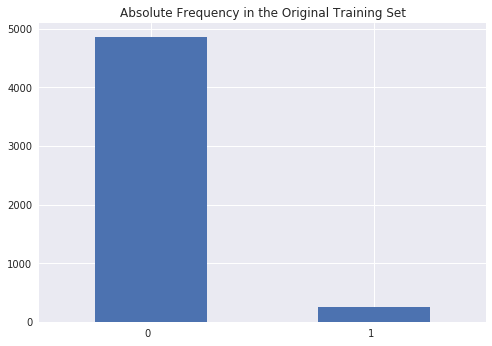

In [5]:
import matplotlib.pyplot as plt
with plt.style.context('seaborn'):
    ax = df['stroke'].value_counts().plot(kind='bar')
    ax.set_xticklabels(target_values_dict.keys(), rotation = 0, ha="right")
    ax.set_title('Absolute Frequency in the Original Training Set')

We have an imbalanced dataset: just a few strokes - 249 - were observed out of a total sample of 5110. Typically, in this scenario, if we try to fit a model on those imbalanced dataset, it is likely to get a biased model, since the model will always predict the most common training class, regarding the observed values for a particular example.

We have also a few categorical variables: you can get a validated list from the code below here, which has been filled for you.

In [6]:
groups_variables = df.columns.to_series().groupby(df.dtypes).groups
my_dict = {k.name: v for k, v in groups_variables.items()}
my_dict['object'].values

array(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'], dtype=object)

In [10]:
groups_variables

{int64: ['id', 'hypertension', 'heart_disease', 'stroke'], float64: ['age', 'avg_glucose_level', 'bmi'], object: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']}

In [11]:
my_dict

{'int64': Index(['id', 'hypertension', 'heart_disease', 'stroke'], dtype='object'),
 'float64': Index(['age', 'avg_glucose_level', 'bmi'], dtype='object'),
 'object': Index(['gender', 'ever_married', 'work_type', 'Residence_type',
        'smoking_status'],
       dtype='object')}

We are going to transform those variables with the most appropriate preprocessing method later in this lab.

# 2. Preprocessing 

## 2.1 Encoding Categorical Variables

We have five categorical variables that need to be processed before ingesting them in a classifier. Let's look at all their possible values: we create a dictionary with key the feature's name and as values the distinct values that it might take.

In [8]:
my_new_dict = {}
for elem in my_dict['object'].values:
    my_new_dict[elem] = df[elem].drop_duplicates().to_list()

In [9]:
my_new_dict

{'gender': ['Male', 'Female', 'Other'],
 'ever_married': ['Yes', 'No'],
 'work_type': ['Private',
  'Self-employed',
  'Govt_job',
  'children',
  'Never_worked'],
 'Residence_type': ['Urban', 'Rural'],
 'smoking_status': ['formerly smoked', 'never smoked', 'smokes', 'Unknown']}

They all look like nominal variables, meaning that each single variable has a finite set of discrete values with no relationship between values. For the sake of completeness, there exists also another set of categorical variables, called ordinal, where values are ranked with respect to some benchmark measure. An example is a weekday: Sunday is always after Saturday, and possibly you want to map this order in your data. Or, the education level: having a Phd is more important than a bachelor.

#### Challenge

You are asked to perform a One-hot Encoding using *scikit-learn* on the following columns: `'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'`. To do so, you have to

 1. Import the `OneHotEncoder` class from the `preprocessing` submodule. This has been done for you. <br>
 2. Initialize an `OneHotEncoder` with the argument `sparse=False`; and then  <br>
 3. Transform the selected columns from the original data `df` using the One Hot Encoder. <br>
 4. You then need to store the encoded data into the variable `encoded_data`
 
**Hint**: To transform just the categorical variables, use `df[my_dict['object'].values]` inside the `fit_transform` call.

In [12]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
encoded_data = ohe.fit_transform(df[my_dict['object'].values])

Now, the following snippet is going to pass the `encoded_data` to a `pandas.DataFrame`, and we specify as columns' name the result coming from `ohe.get_feature_names(my_dict['object'].values))`. This is done for you in the next cell.

In [13]:
encoded_data_df = pd.DataFrame(encoded_data, columns= list(ohe.get_feature_names(my_dict['object'].values)))
encoded_data_df.head()

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


#### Challenge
We now merge the original dataframe `df` dropped by the categorical variables and the `encoded_data_df`. To do so, you are asked to use the `pandas.concat` method.

1. Create a variable called `cleaned_df` where we drop all the categorical columns.  <br>
2. Concat the `cleaned_df` and the `encoded_data_df` using the `pd.concat` method. You should concatenate the two data frames by columns, so specify `axis=1` in the call. Store this into the variable `df_all`.

In [14]:
cleaned_df = df.drop(my_dict['object'].values, axis=1)
df_all = pd.concat([cleaned_df, encoded_data_df], axis=1)

Let us inspect the first 5 rows of the new dataframe

In [15]:
df_all.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,51676,61.0,0,0,202.21,NaN,1,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,31112,80.0,0,1,105.92,32.5,1,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,60182,49.0,0,0,171.23,34.4,1,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1665,79.0,1,0,174.12,24.0,1,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# ====================================
# Validation Check
# DO NOT CHANGE THIS CELL
# ====================================
vcf_01 =  [len(list(ohe.get_feature_names(my_dict['object'].values))), df_all.shape[0]]
with open('results/vcf_ml_clf_01.txt', 'w') as f:
    for item in vcf_01:
        f.write("%s\n" % item)

## 2.2 Imputing Missing Values

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#### Challenge

You are asked to perform the required imputation. To do so, you have to
 1. Initialize an `IterativeImputer` with `random_state=42`; and then 
 2. Transform the original data `df` using the Iterative Imputer.
 3. You then need to store the imputed data into the variable `imputed_data_df`
 
**Hint**: To store the imputed data into a `pandas.DataFrame`, you might find useful the following instruction: `pd.DataFrame(new_object, columns=list(df))`, where `new_object` is the results of point 2.

In [18]:
# Challenge
imputed_data = IterativeImputer()
imputed_data_df = pd.DataFrame(imputed_data.fit_transform(df_all), columns=list(df_all))

In [19]:
imputed_data_df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046.0,67.0,0.0,1.0,228.69,36.600000,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,51676.0,61.0,0.0,0.0,202.21,31.127421,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,31112.0,80.0,0.0,1.0,105.92,32.500000,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,60182.0,49.0,0.0,0.0,171.23,34.400000,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1665.0,79.0,1.0,0.0,174.12,24.000000,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [20]:
# ====================================
# Validation Check
# DO NOT CHANGE THIS CELL
# ====================================
with open('results/vcf_ml_clf_02.txt', 'w') as f:
    f.write("%s\n" % round(imputed_data_df.iloc[1,5], 4))

# 3. Dataset creation

We now separate the target variable from the features. This is a standard step when one builds a machine learning pipeline. This is done in the next cell.

In [21]:
X = imputed_data_df.drop(['stroke'], axis=1)
y = imputed_data_df['stroke']

We also need to split the data into a training and a test set: the two sets are made independent of each other. The training set is used to learn specific patterns in the data, whereas the test set is then used to test the prediction power of the trained model on new data. Note that we are going to split the data with a 80/20 strategy: 80% are used as training set, the remaining 20% as test set. Also, note that we specify `stratify` equal to the target variable `y`: this is very important in presence of imbalanced datasets. Indeed, by setting `stratify=y`, each dataset contains approximately the same percentage of samples of each target class as the complete set. This step has been done for you in the cell below here:

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 3.1 Dealing with Imbalanced Data

Fitting a model with imbalanced data is quite risky: in this scenario, it is likely to get a biased model, since the model will always predict the most common training class, regarding the observed values for a particular example. Hence, it is necessary to perform a sophisticated data transformation, called Synthetic Minority Oversampling TEchnique, SMOTE. We are not going into the formal details of such an algorithm in this lab. However, the most important thing for you to understand is that this algorithm is going to create new, synthetic data for the `minority` class, and associate a label to those examples using a statistical model called k-nearest Neighbours. The output is a new dataset, on which the minority class is going to have a ratio of 1:1 with respect to the majority class.

This is done for you in the next snippet.

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority')
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train.ravel())

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.2

A simple inspection of the new target training data, `y_train_smote`, confirms the 1:1 ratio between training classes.

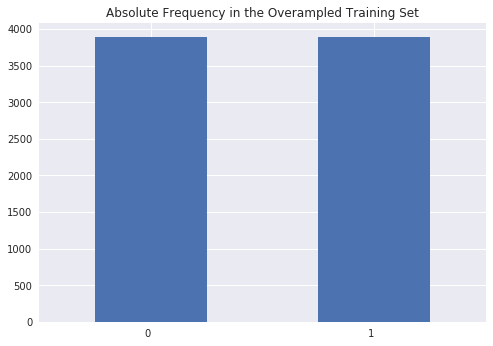

In [21]:
with plt.style.context('seaborn'):
    ax = pd.DataFrame(y_train_smote).value_counts().plot(kind='bar')
    ax.set_xticklabels(target_values_dict.keys(), rotation = 0, ha="right")
    ax.set_xlabel('')
    ax.set_title('Absolute Frequency in the Overampled Training Set')

# 4. Model Fitting and Evaluation

## 4.1 Fitting

We are now ready to fit a classifier to predict the probability of a patient will suffer from heart stroke. To do so, we are going to perform two steps:
 1. we are going to scale the original data using a `StandardScaler`; <br>
 2. we are going to fit a model using a `LogisticRegression`.<br>

We could perform the two steps separately, but in this case we are going to use a sklearn `Pipeline` object: a pipeline is a sort of wrapper that ingest a series of steps needed to perform model fitting with scikit-learn. It is indeed a great feature that helps you in performing complex machine learning pipelines by gaining efficiency in computation and performances, as the model complexity grows. In particular, the order of the steps you define inside a pipeline is crucial, since the output of each step is going to be the input of the successive step.

In our case, the pipeline is pretty easy: we need to first perform scaling, and then the fitting procedure. So, we make the necessary imports. This has been done for you in the next cell.


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

#### Challenge
You are asked to initialize a pipeline object. The steps go as follows:
1. Initialize a `Pipeline` object by specifying the `steps` argument as a list made of two steps: `StandardScaler` and `Logisticregression`. You can use the following snippet inside the `Pipeline` call:

```python
    steps = [
        ('scale',StandardScaler()),
        ('lr',LogisticRegression())
    ]
```
2. Store the initialized `Pipeline` object inside the variable `lr_pipeline`.

In [23]:
lr_pipeline = Pipeline(
    steps = [
        ('scale',StandardScaler()),
        ('lr',LogisticRegression())
    ]
)

A Logistic Regression model has several hyperparameters: among many it is worth to mention the following ones:
 - `C`: it controls the regularization effect. Indeed, the logistic regression applies a L2-norm by default. Since C is defined as the inverse of the regularization effect, lower C means higher regularization. <br>
 - `max_iter`: it controls the convergence of the model: higher values associated to this parameter translates into a better estimation.
 
There are several other arguments: if curious, I strongly encourage you to check the official documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Having hyperparameters to be estimated requires us to perform a Grid Search cross-validation. In a Grid Search cross-validation, we are going to define a grid of possible values for our hyperparameters, and then we estimate different models with different combinations of those hyperparameters using cross-validation. If this terminology is not familiar to you, I strongly encourage you to watch the course `Building a Machine Learning pipeline with scikit-learn: part 02`.

To perform grid search cross-validation in scikit learn, we use the `GridSearchCV` method from the `model_selection` submodule. In this lab, we are going to explore a small grid, but obviously you can play with it, and check how the model performances vary using different sets of hyperparameters. Here, I have defined a grid for the parameter C, which I assume it might take twenty possible values in a specific range. This is done for you below here.

```python
param_grid = {
    'lr__C': np.logspace(-8, 8, 20),
}
```

In a scikit-learn pipeline, those parameters can be specified using the `__` symbol, which is used to separate parameter names from the pipeline step. So, we make the necessary imports: this is done for you in the next cell.

In [25]:
from sklearn.model_selection import GridSearchCV
import numpy as np

#### Challenge

You are asked to perform a *Grid search cross-validation* to obtain both the best estimator and the best hyper-parameter C value for the given `param_grid`.
```python
param_grid = {
    'lr__C': np.logspace(-8, 8, 20),
}
```
In particular, you have to:
1. initialize a `GridSearchCV` object by passing: 
 - the `lr_pipeline` estimator,  <br>
 - the `param_grid` set to be equal to `param_grid`, 
 - the `n_jobs` equal to -1, and <br>
 - the `cv` argument equal to 5. <br>

Store this new object into the variable `grid_cv`. <br>

2. we fit the `grid_cv` with `X_train_smote` and `y_train_smote`.


In [26]:
param_grid = {
    'lr__C': np.logspace(-8, 8, 20),
}
grid_cv = GridSearchCV(lr_pipeline, param_grid, n_jobs=-1, cv=5)
grid_cv.fit(X_train_smote, y_train_smote)

/Users/thegiuss/.virtualenvs/clouda_ml_labs/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='warn',

Let us print both the `best_score` and `best_params`:

In [27]:
print(f"Best CV Score {round(grid_cv.best_score_, 4)}")
print(f"Best HyperParameter C: {round(grid_cv.best_params_['lr__C'],4)}")

Best CV Score 0.7963
Best HyperParameter C: 0.0078


In [28]:
# ====================================
# Validation Check
# DO NOT CHANGE THIS CELL
# ====================================
vcf_03 = [str(lr_pipeline), round(grid_cv.best_score_, 4), grid_cv.best_params_['lr__C']]
with open('results/vcf_ml_clf_03.txt', 'w') as f:
    for item in vcf_03:
        f.write("%s\n" % item)

We now predict on new data, using the `X_test` set and the best model `grid_cv.best_estimator_`. This is done for you in the next cell.

In [29]:
y_pred = grid_cv.best_estimator_.predict(X_test)

## 4.2 Evaluation

To measure the performance of a classification task, we typically employ four main indicators: accuracy, precision, recall, and f1-score. The first three can be retrieved from the confusion matrix, which is computed in the next snippet.

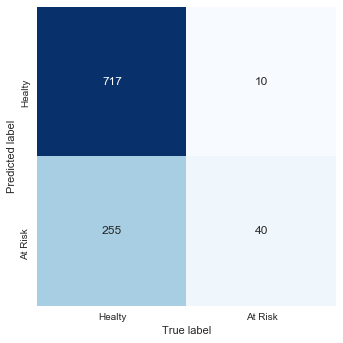

In [30]:
from egeaML.egeaML import classification_plots
labels = ['Healty', 'At Risk']
with plt.style.context('seaborn'):
    classification_plots.confusion_matrix(y_test, y_pred, cmap='Blues', xticklabels=labels, yticklabels=labels)

Interestingly, the model has correctly estimated 40 examples who are at risk of having a stroke: those are called True Positive. However, on the same side we have a large number that are estimated at risk when they are actually observed as healthy - 247 -. Those are called False Positive. 

Overall, are we happy with this model? Does this make sense? 

Well, there is no leading response in answering to this question, namely the choice of the metric to maximize is strictly dependent on the domain under investigation.

In our case, it might be relevant to maximize the recall, since we would like to prevent a hearth stroke in patients, and therefore a high recall means higher number of subjects that are classified as at risk when they are actually healthy: that is why the recall is also called *false positive rate*.

Note that we also get a small number of patients - 10 - who are at risk but are classified as healthy. In general, this set is called False negative, and we want to minimize it, regarding the strategy we have chosen.

We can get a better understanding of the class-specific precision and recall by using the scikit-learn `classification_report`, which can be easily imported from the `metrics` submodule.

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.74      0.84       972
         1.0       0.14      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.74      0.81      1022



The model has quite a higher recall on the positive class, as expected, and a quite good overall accuracy. We could be happy with this basic model as a baseline for more advanced models.

# END